Checking missing values:
koi_score            5855
koi_teq_err2         5855
koi_teq_err1         5855
kepler_name          3163
koi_tce_plnt_num      718
koi_tce_delivname     718
koi_steff_err2        212
koi_steff_err1        195
koi_srad_err1         195
koi_srad_err2         195
dtype: int64
Total confirmed planets: 2691


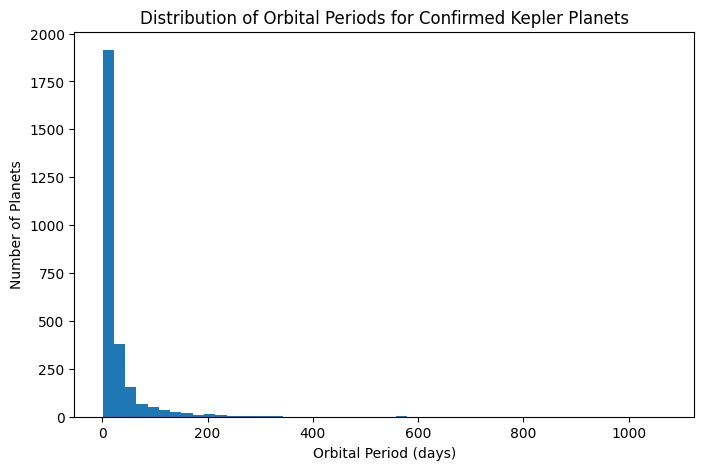

Potentially habitable candidates: 31


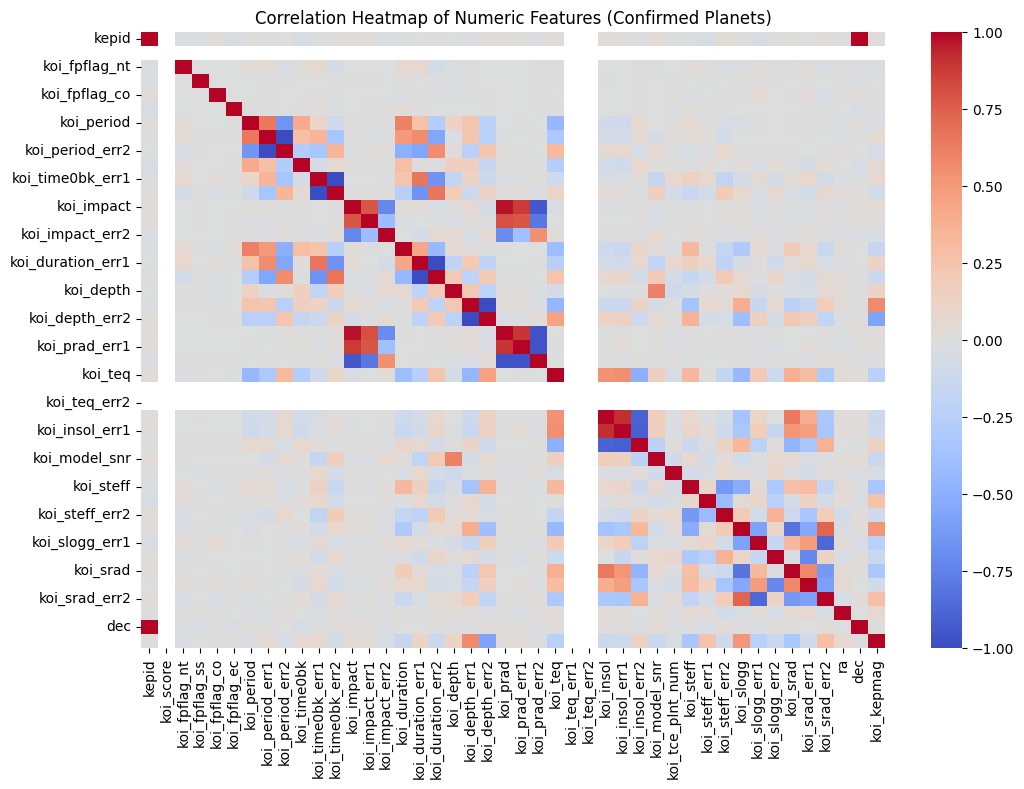

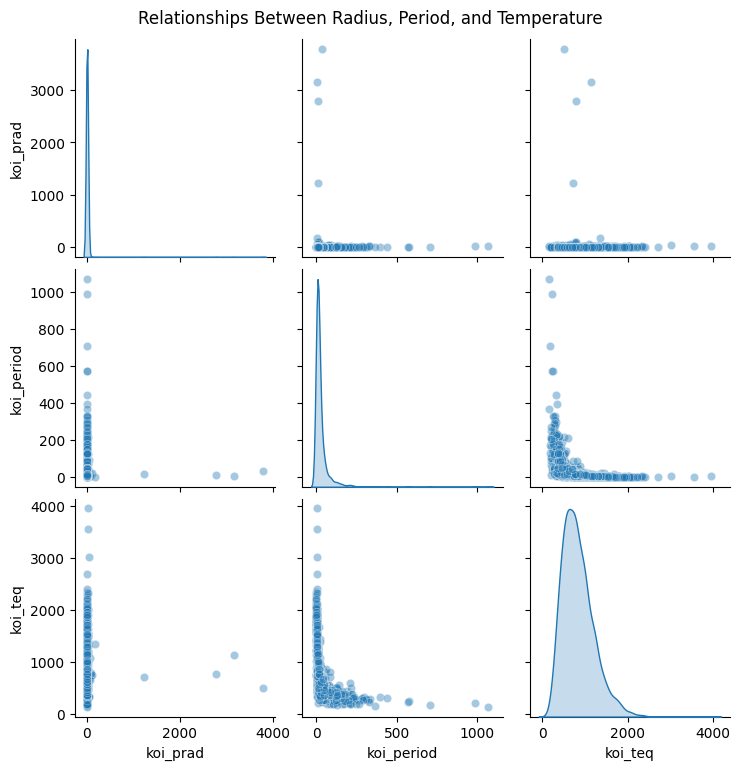

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       268
           1       0.88      0.93      0.91       558

    accuracy                           0.87       826
   macro avg       0.86      0.84      0.85       826
weighted avg       0.87      0.87      0.87       826



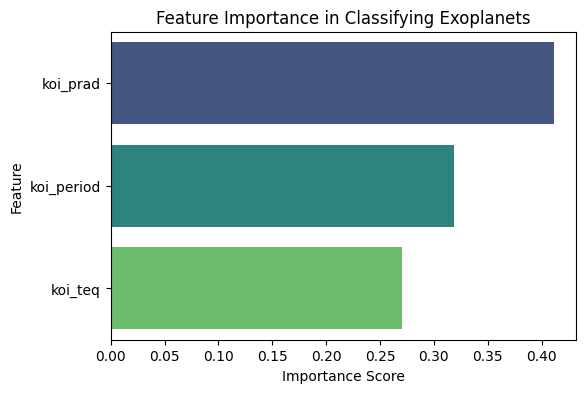

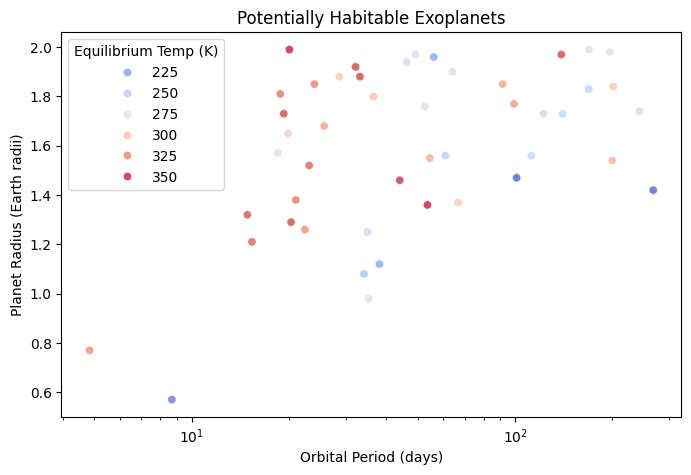

Number of potentially habitable candidates: 47


NameError: name 'koi_plot' is not defined

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
from IPython.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

url = "https://raw.githubusercontent.com/zebaerum/AstroQuestAI/refs/heads/main/KOICatalog.csv"
# Load KOI dataset
koi = pd.read_csv(url, comment="#")

# Show first 5 rows
koi.head()
# Basic data info
print("Checking missing values:")
print(koi.isnull().sum().sort_values(ascending=False).head(10))  # check missing values
confirmed = koi[koi['koi_disposition'] == "CONFIRMED"]
print(f"Total confirmed planets: {len(confirmed)}")
confirmed.head()
plt.figure(figsize=(8,5))
plt.hist(confirmed['koi_period'], bins=50)
plt.xlabel("Orbital Period (days)")
plt.ylabel("Number of Planets")
plt.title("Distribution of Orbital Periods for Confirmed Kepler Planets")
plt.show()

habitable = confirmed[
    (confirmed['koi_prad'] < 2.0) &      # Radius < 2 Earth radii
    (confirmed['koi_teq'] > 180) &       # Temperature range
    (confirmed['koi_teq'] < 310)
]

print(f"Potentially habitable candidates: {len(habitable)}")
habitable[['kepoi_name','koi_prad','koi_teq','koi_period']].head()

# Select only numeric columns
numeric_cols = confirmed.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_cols.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features (Confirmed Planets)")
plt.show()

sns.pairplot(
    confirmed[['koi_prad','koi_period','koi_teq']],
    diag_kind='kde',
    plot_kws={'alpha':0.4}
)
plt.suptitle("Relationships Between Radius, Period, and Temperature", y=1.02)
plt.show()


# Filter confirmed + false positive
binary_koi = koi[koi['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])]

# Prepare features (drop NA)
X = binary_koi[['koi_period','koi_prad','koi_teq']].dropna()
y = binary_koi.loc[X.index, 'koi_disposition'].map({'CONFIRMED':1,'FALSE POSITIVE':0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

import numpy as np

# Get feature importances from the model
importances = model.feature_importances_
feature_names = X.columns

# Sort them
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis", dodge=False,
    legend=False)
plt.title("Feature Importance in Classifying Exoplanets")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

summary = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

summary

habitable = confirmed[
    (confirmed['koi_prad'].between(0.5, 2.0)) &
    (confirmed['koi_teq'].between(200, 350))
]

plt.figure(figsize=(8,5))
sns.scatterplot(data=habitable, x="koi_period", y="koi_prad", hue="koi_teq", palette="coolwarm", alpha=0.7)
plt.xscale("log")
plt.xlabel("Orbital Period (days)")
plt.ylabel("Planet Radius (Earth radii)")
plt.title("Potentially Habitable Exoplanets")
plt.legend(title="Equilibrium Temp (K)")
plt.show()

print(f"Number of potentially habitable candidates: {habitable.shape[0]}")

# Drop rows with missing values in the columns we’ll plot
koi_plot = koi.dropna(subset=["Equilibrium_Temp", "Planet_Radius", "koi_disposition"])

# Check unique dispositions
print(koi_plot["koi_disposition"].unique())

palette_dict = {
    "CONFIRMED": "green",
    "CANDIDATE": "blue",
    "FALSE POSITIVE": "red",
    "NOT DISPOSITIONED": "gray"
}

# Rename columns for easier use
koi.rename(columns={
    "koi_prad": "Planet_Radius",
    "koi_period": "Orbital_Period",
    "koi_teq": "Equilibrium_Temp"
}, inplace=True)


# Scatter plot: Planet Radius vs Equilibrium Temperature
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=koi_plot,
    x="Equilibrium_Temp",
    y="Planet_Radius",
    hue="koi_disposition",
    palette=palette_dict,
    alpha=0.6
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel("Planet Radius (Earth Radii)")
plt.title("Planet Radius vs Equilibrium Temperature")
plt.legend(title="Disposition")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=koi, x="koi_disposition", palette=palette_dict)
plt.xlabel("Disposition")
plt.ylabel("Number of Planets")
plt.title("Counts of Kepler Planet Dispositions")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(8,5))
# Drop missing values for Orbital_Period
orbital_data = koi.dropna(subset=["Orbital_Period"])

plt.hist(orbital_data["Orbital_Period"], bins=50, color="skyblue", edgecolor="black")
plt.xscale("log")  # orbital periods vary widely; log scale makes sense
plt.xlabel("Orbital Period (days)")
plt.ylabel("Number of Planets")
plt.title("Distribution of Orbital Periods for Kepler Candidates")
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Binary classification target
# 1 if confirmed or candidate, 0 if false positive or not dispositioned
koi_plot = koi.dropna(subset=["koi_disposition"])  # only keep rows with disposition

koi_plot["target"] = koi_plot["koi_disposition"].apply(lambda x: 1 if x in ["CONFIRMED","CANDIDATE"] else 0)

features = ["Planet_Radius", "Orbital_Period", "Equilibrium_Temp"]
X = koi_plot[features]
y = koi_plot["target"]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_true = y_test


# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Create a summary table
metrics_summary = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Value": [accuracy, precision, recall, f1]
})

# Display table
metrics_summary

metrics_summary.to_csv("ML_metrics_summary.csv", index=False)

plt.figure(figsize=(8,5))
koi_plot = koi.dropna(subset=["Planet_Radius", "Orbital_Period", "koi_disposition"])

sns.scatterplot(
    data=koi_plot,
    x="Orbital_Period",
    y="Planet_Radius",
    hue="koi_disposition",
    palette={"CONFIRMED":"green", "CANDIDATE":"blue", "FALSE POSITIVE":"red", "NOT DISPOSITIONED":"gray"},
    alpha=0.6
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Orbital Period (days)")
plt.ylabel("Planet Radius (Earth Radii)")
plt.title("Kepler Exoplanet Candidates by Disposition")
plt.legend(title="Disposition")
plt.show()
